# Synthetic dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer
import matplotlib.pyplot as plt
import shap

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['legend.fontsize'] = 16

def plot_contribution(b, k=3, size=50, title=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i),fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
        else:
            c = ax.imshow(b[i].reshape(size, size), cmap=plt.get_cmap('viridis', 36), vmin=vmin, vmax=vmax, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(axis='x', colors=(0,0,0,0))
            ax.tick_params(axis='y', colors=(0,0,0,0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.png', bbox_inches='tight')

## Data generation

In [3]:
size = 50

b0 = np.ones((size, size))
b1 = np.ones((size, size))
b2 = np.ones((size, size))
b3 = np.ones((size, size))
b4 = np.ones((size, size))
noise = np.ones((size, size))

for i in range(size):
    for j in range(size):
        b0[i, j] = 6 * np.exp(-((i - 25)**2 + (j - 25)**2) / (2 * 15**2))
        b1[i, j] = i / 49 * 6
        b2[i, j] = (i + j) / 49 * 3
        b3[i, j] = 6 * np.exp(-((i - 25)**2 + (j - 25)**2) / (2 * 12**2))
        # b3[i, j] = (j / 49) * 6
        # b3[i, j] = 6 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 6 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))
        noise[i, j] = 2 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 2 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))

# b3 = np.flip(b2, axis=1).T
# b3 = np.ones(size*size).reshape(-1)*2


In [4]:
# b0 = b0.reshape(-1)
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
b3 = b3.reshape(-1)
# b4 = b4.reshape(-1)
noise = noise.reshape(-1)

In [5]:
np.random.seed(222)

X1 = np.random.uniform(-2, 2, size * size)
X2 = np.random.uniform(-2, 2, size * size)
X3 = np.random.uniform(-2, 2, size * size)
X4 = np.random.uniform(-2, 2, size * size)
X5 = np.random.uniform(-2, 2, size * size)

X = np.vstack([X1, X2, X3, X4, X5]).T
u = np.array([np.linspace(0,size - 1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size - 1,num=size)]*size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

k = X.shape[1]
n = X.shape[0]

In [6]:
X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1), columns=['X1', 'X2', 'X3', 'X4', 'X5', 'x_coord', 'y_coord'])

In [7]:
X_coords

X1        X2        X3        X4        X5  x_coord  y_coord
0     0.104114  0.964917  1.011381  1.192011  1.623438      0.0      0.0
1     0.741269 -0.440030 -0.936705  1.024414  1.663881      1.0      0.0
2     1.342697 -0.875739 -1.148677 -1.992029 -0.209243      2.0      0.0
3     0.615061  1.082512 -1.266801 -0.424231  0.540090      3.0      0.0
4    -1.851912  0.026923 -0.659943  1.062233 -0.125796      4.0      0.0
...        ...       ...       ...       ...       ...      ...      ...
2495 -1.798074 -0.779403  0.012337 -1.363451 -1.925222     45.0     49.0
2496  0.239688 -0.666447  0.497581  0.348732  0.100871     46.0     49.0
2497 -1.719665 -1.038000 -0.700350  1.508266  0.610802     47.0     49.0
2498 -0.650496 -1.045958  0.776005  1.999300  1.650016     48.0     49.0
2499  0.801800 -0.750421  0.581807  0.487717  1.276653     49.0     49.0

[2500 rows x 7 columns]

In [8]:
# f0 = b0
f1 = b1 * X_coords.values[:, 0]
f2 = b2 * X_coords.values[:, 1]
f3 = b3 * X_coords.values[:, 2]
f4 = X_coords.values[:, 3] * 2
f5 = X_coords.values[:, 4] ** 2

In [9]:
y = pd.DataFrame(f1 + f2 + f3 + f4 + f5 + noise, columns=['y'])

In [10]:
b = [b1, b2, b3, [X_coords.values[:, 3], f4, -6, 6], [X_coords.values[:, 4], f5, -1, 5], noise]

In [11]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$', r'$f_5(X_5)$', 'noise']

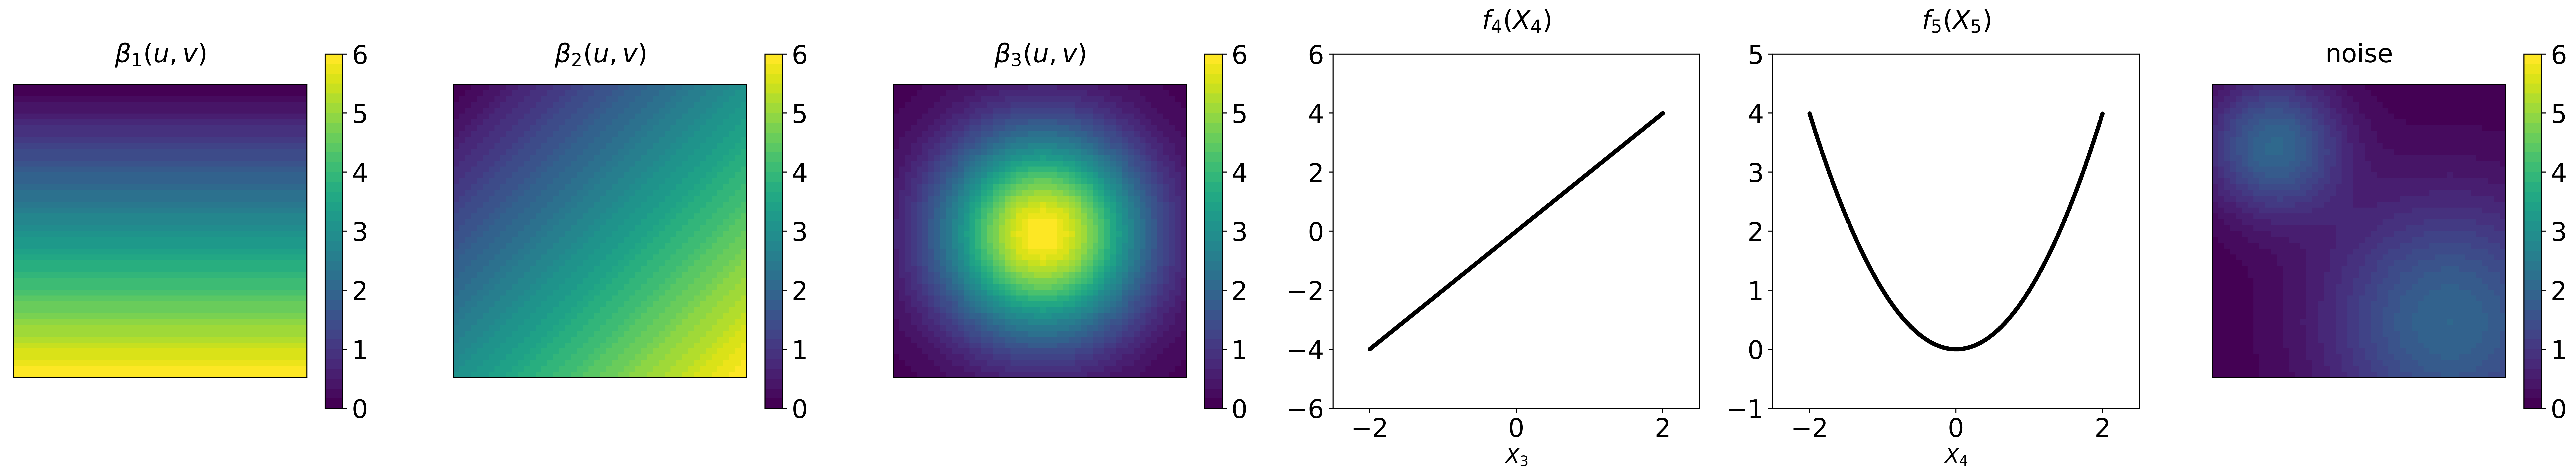

In [12]:
plot_contribution(b=b, k=6, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation', non_spatial=[3, 4])

In [13]:
class Model:
    def __init__(self, f):
        self.predict = f

In [14]:
def predict(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    n, k = X_coords.shape
    y_pred = []

    for i in range(n):
        u = X_coords[i, -1]
        v = X_coords[i, -2]
        # f0 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 15**2))
        f1 = u / 49 * 6 * X_coords[i,0]
        f2 = (u + v) / 49 * 3 * X_coords[i,1]
        f3 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 12**2)) * X_coords[i, 3]
        f4 = X_coords[:, 3] * 2
        f5 = X_coords[:, 4] ** 2
        noise = 2 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 2 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))

        # y = f0 + f1 + f2 + f3 + f4
        y = f1 + f2 + f3 + f4 + f5 + noise
        y_pred.append(y)
    return np.array(y_pred)

In [15]:
true_model = Model(predict)

In [16]:
loc = X_coords[['x_coord', 'y_coord']]

In [17]:
X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [18]:
X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5, random_state=42)

In [19]:
X_train, X_calib, loc_train, loc_calib = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [20]:
explainer = GeoConformalizedExplainer(true_model, X_train, X_calib, loc_calib.values, loc.values, 0.1, 15)

In [21]:
X_coords

X1        X2        X3        X4        X5  x_coord  y_coord
0     0.104114  0.964917  1.011381  1.192011  1.623438      0.0      0.0
1     0.741269 -0.440030 -0.936705  1.024414  1.663881      1.0      0.0
2     1.342697 -0.875739 -1.148677 -1.992029 -0.209243      2.0      0.0
3     0.615061  1.082512 -1.266801 -0.424231  0.540090      3.0      0.0
4    -1.851912  0.026923 -0.659943  1.062233 -0.125796      4.0      0.0
...        ...       ...       ...       ...       ...      ...      ...
2495 -1.798074 -0.779403  0.012337 -1.363451 -1.925222     45.0     49.0
2496  0.239688 -0.666447  0.497581  0.348732  0.100871     46.0     49.0
2497 -1.719665 -1.038000 -0.700350  1.508266  0.610802     47.0     49.0
2498 -0.650496 -1.045958  0.776005  1.999300  1.650016     48.0     49.0
2499  0.801800 -0.750421  0.581807  0.487717  1.276653     49.0     49.0

[2500 rows x 7 columns]

In [ ]:
results = explainer.uncertainty_aware_explain(x_test=X_coords, n_jobs=16)

In [22]:
results.accuracy_summary()

coverage_probability        R2      RMSE   SHAP_Var  Pred_SHAP_Var
X1                     0.8796  0.988827  0.400440  14.352294      13.678031
X2                     1.0000  0.991627  0.339234  13.744198      13.321598
X3                     0.0380  0.982831  0.483592  13.620757      13.448969
X4                     0.9992  0.997689  0.119632   6.194027       6.465845
x_coord                0.9780  0.960346  0.268181   1.813697       1.772653
y_coord                0.9808  0.936367  0.343934   1.858943       1.748452

In [23]:
pred_results = results.result

In [24]:
results.result_geo

X1_shap   X2_shap   X3_shap   X4_shap  x_coord_shap  y_coord_shap  \
0     0.360768  1.494056  1.626706  0.957656     -2.680179     -1.102175   
1     1.430568 -0.809202 -1.483384  1.011317      1.488011     -1.120366   
2     2.456744 -1.525168 -1.932687 -1.531911      2.966117     -0.475414   
3     1.210124  1.788547 -2.216772 -0.315539      1.275717     -1.499111   
4    -2.914610 -0.010401 -1.200243  1.041880      0.694268      2.793437   
...        ...       ...       ...       ...           ...           ...   
2495 -7.585292 -3.480166  0.201668 -1.235720     -0.115538     -2.703412   
2496  1.949262 -2.973297  2.323236  0.371554      0.009898     -0.691236   
2497 -7.259140 -4.665640 -2.985915  1.543205     -2.259692     -4.030546   
2498 -2.232229 -4.757432  3.655893  1.803471     -0.476942     -2.724161   
2499  4.570961 -3.428434  2.824326  0.438700      0.030704     -0.019923   

      X1_value  X2_value  X3_value  X4_value  ...  x_coord_pred  \
0     0.104114  0.964917  1.011381  1.192011  ...     -2.742875   
1     0.741269 -0.440030 -0.936705  1.024414  ...      1.231123   
2     1.342697 -0.875739 -1.148677 -1.992029  ...      2.953261   
3     0.615061  1.082512 -1.266801 -0.424231  ...      1.027685   
4    -1.851912  0.026923 -0.659943  1.062233  ...      0.454266   
...        ...       ...       ...       ...  ...           ...   
2495 -1.798074 -0.779403  0.012337 -1.363451  ...      0.192264   
2496  0.239688 -0.666447  0.497581  0.348732  ...      0.365317   
2497 -1.719665 -1.038000 -0.700350  1.508266  ...     -2.229781   
2498 -0.650496 -1.045958  0.776005  1.999300  ...     -0.076286   
2499  0.801800 -0.750421  0.581807  0.487717  ...      0.472194   

      y_coord_geo_uncertainty  y_coord_uncertainty  y_coord_upper_bound  \
0                    0.671705             0.745862            -0.705714   
1                    0.672479             0.745862            -0.589365   
2                    0.677526             0.745862             0.074915   
3                    0.696683             0.745862            -0.932780   
4                    0.696683             0.745862             3.133805   
...                       ...                  ...                  ...   
2495                 0.887896             0.745862            -1.396463   
2496                 0.887896             0.745862             0.721287   
2497                 0.887896             0.745862            -2.720603   
2498                 0.887896             0.745862            -0.981233   
2499                 0.887896             0.745862             1.349238   

      y_coord_lower_bound  y_coord_coverage_probability  y_coord_pred     x  \
0               -2.049125                        0.9808     -1.377419   0.0   
1               -1.934323                        0.9808     -1.261844   1.0   
2               -1.280137                        0.9808     -0.602611   2.0   
3               -2.326147                        0.9808     -1.629464   3.0   
4                1.740438                        0.9808      2.437121   4.0   
...                   ...                           ...           ...   ...   
2495            -3.172254                        0.9808     -2.284359  45.0   
2496            -1.054504                        0.9808     -0.166608  46.0   
2497            -4.496394                        0.9808     -3.608498  47.0   
2498            -2.757024                        0.9808     -1.869128  48.0   
2499            -0.426553                        0.9808      0.461342  49.0   

         y                   geometry  
0      0.0    POINT (0.00000 0.00000)  
1      0.0    POINT (1.00000 0.00000)  
2      0.0    POINT (2.00000 0.00000)  
3      0.0    POINT (3.00000 0.00000)  
4      0.0    POINT (4.00000 0.00000)  
...    ...                        ...  
2495  49.0  POINT (45.00000 49.00000)  
2496  49.0  POINT (46.00000 49.00000)  
2497  49.0  POINT (47.00000 49.00000)  
2498  49.0  POINT (48.00000 49.00000)  

In [25]:
b = pred_results[['X1_pred', 'X2_pred', 'X3_pred', 'X4_pred', 'x', 'y']]

In [26]:
pred_b = [b['X1_pred'].values, b['X2_pred'].values, b['X3_pred'].values, b['X4_pred'].values]

In [27]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$\beta_{4}(u, v)$']

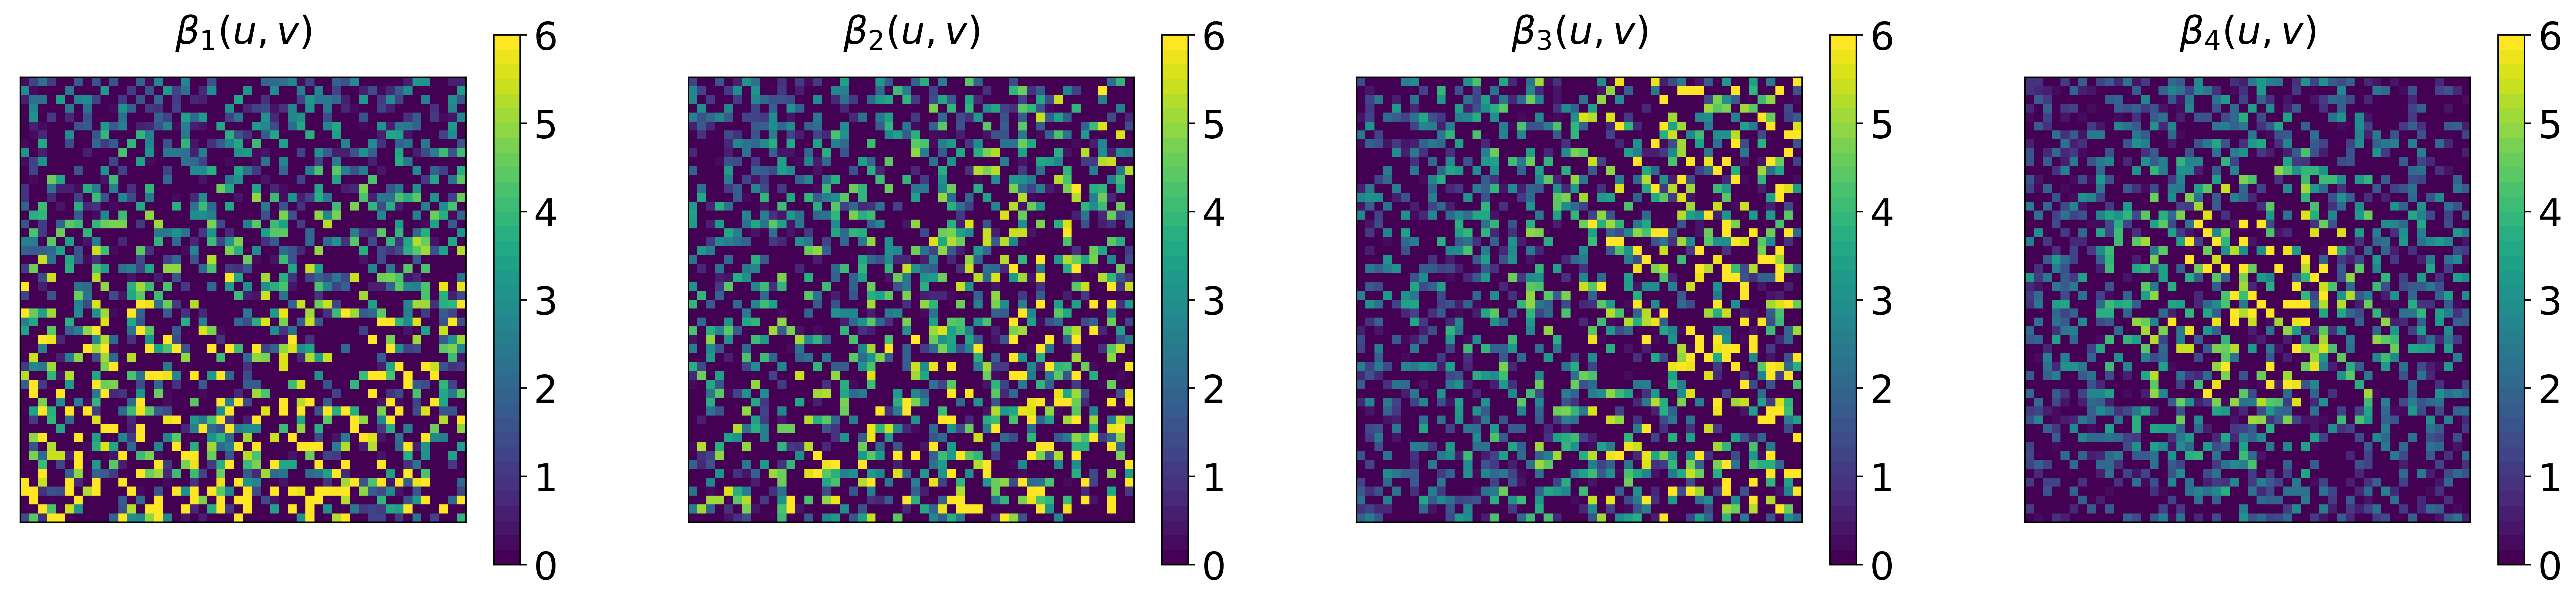

In [28]:
plot_contribution(pred_b, k=4, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[])

In [29]:
plt.rcParams['font.size'] = 16

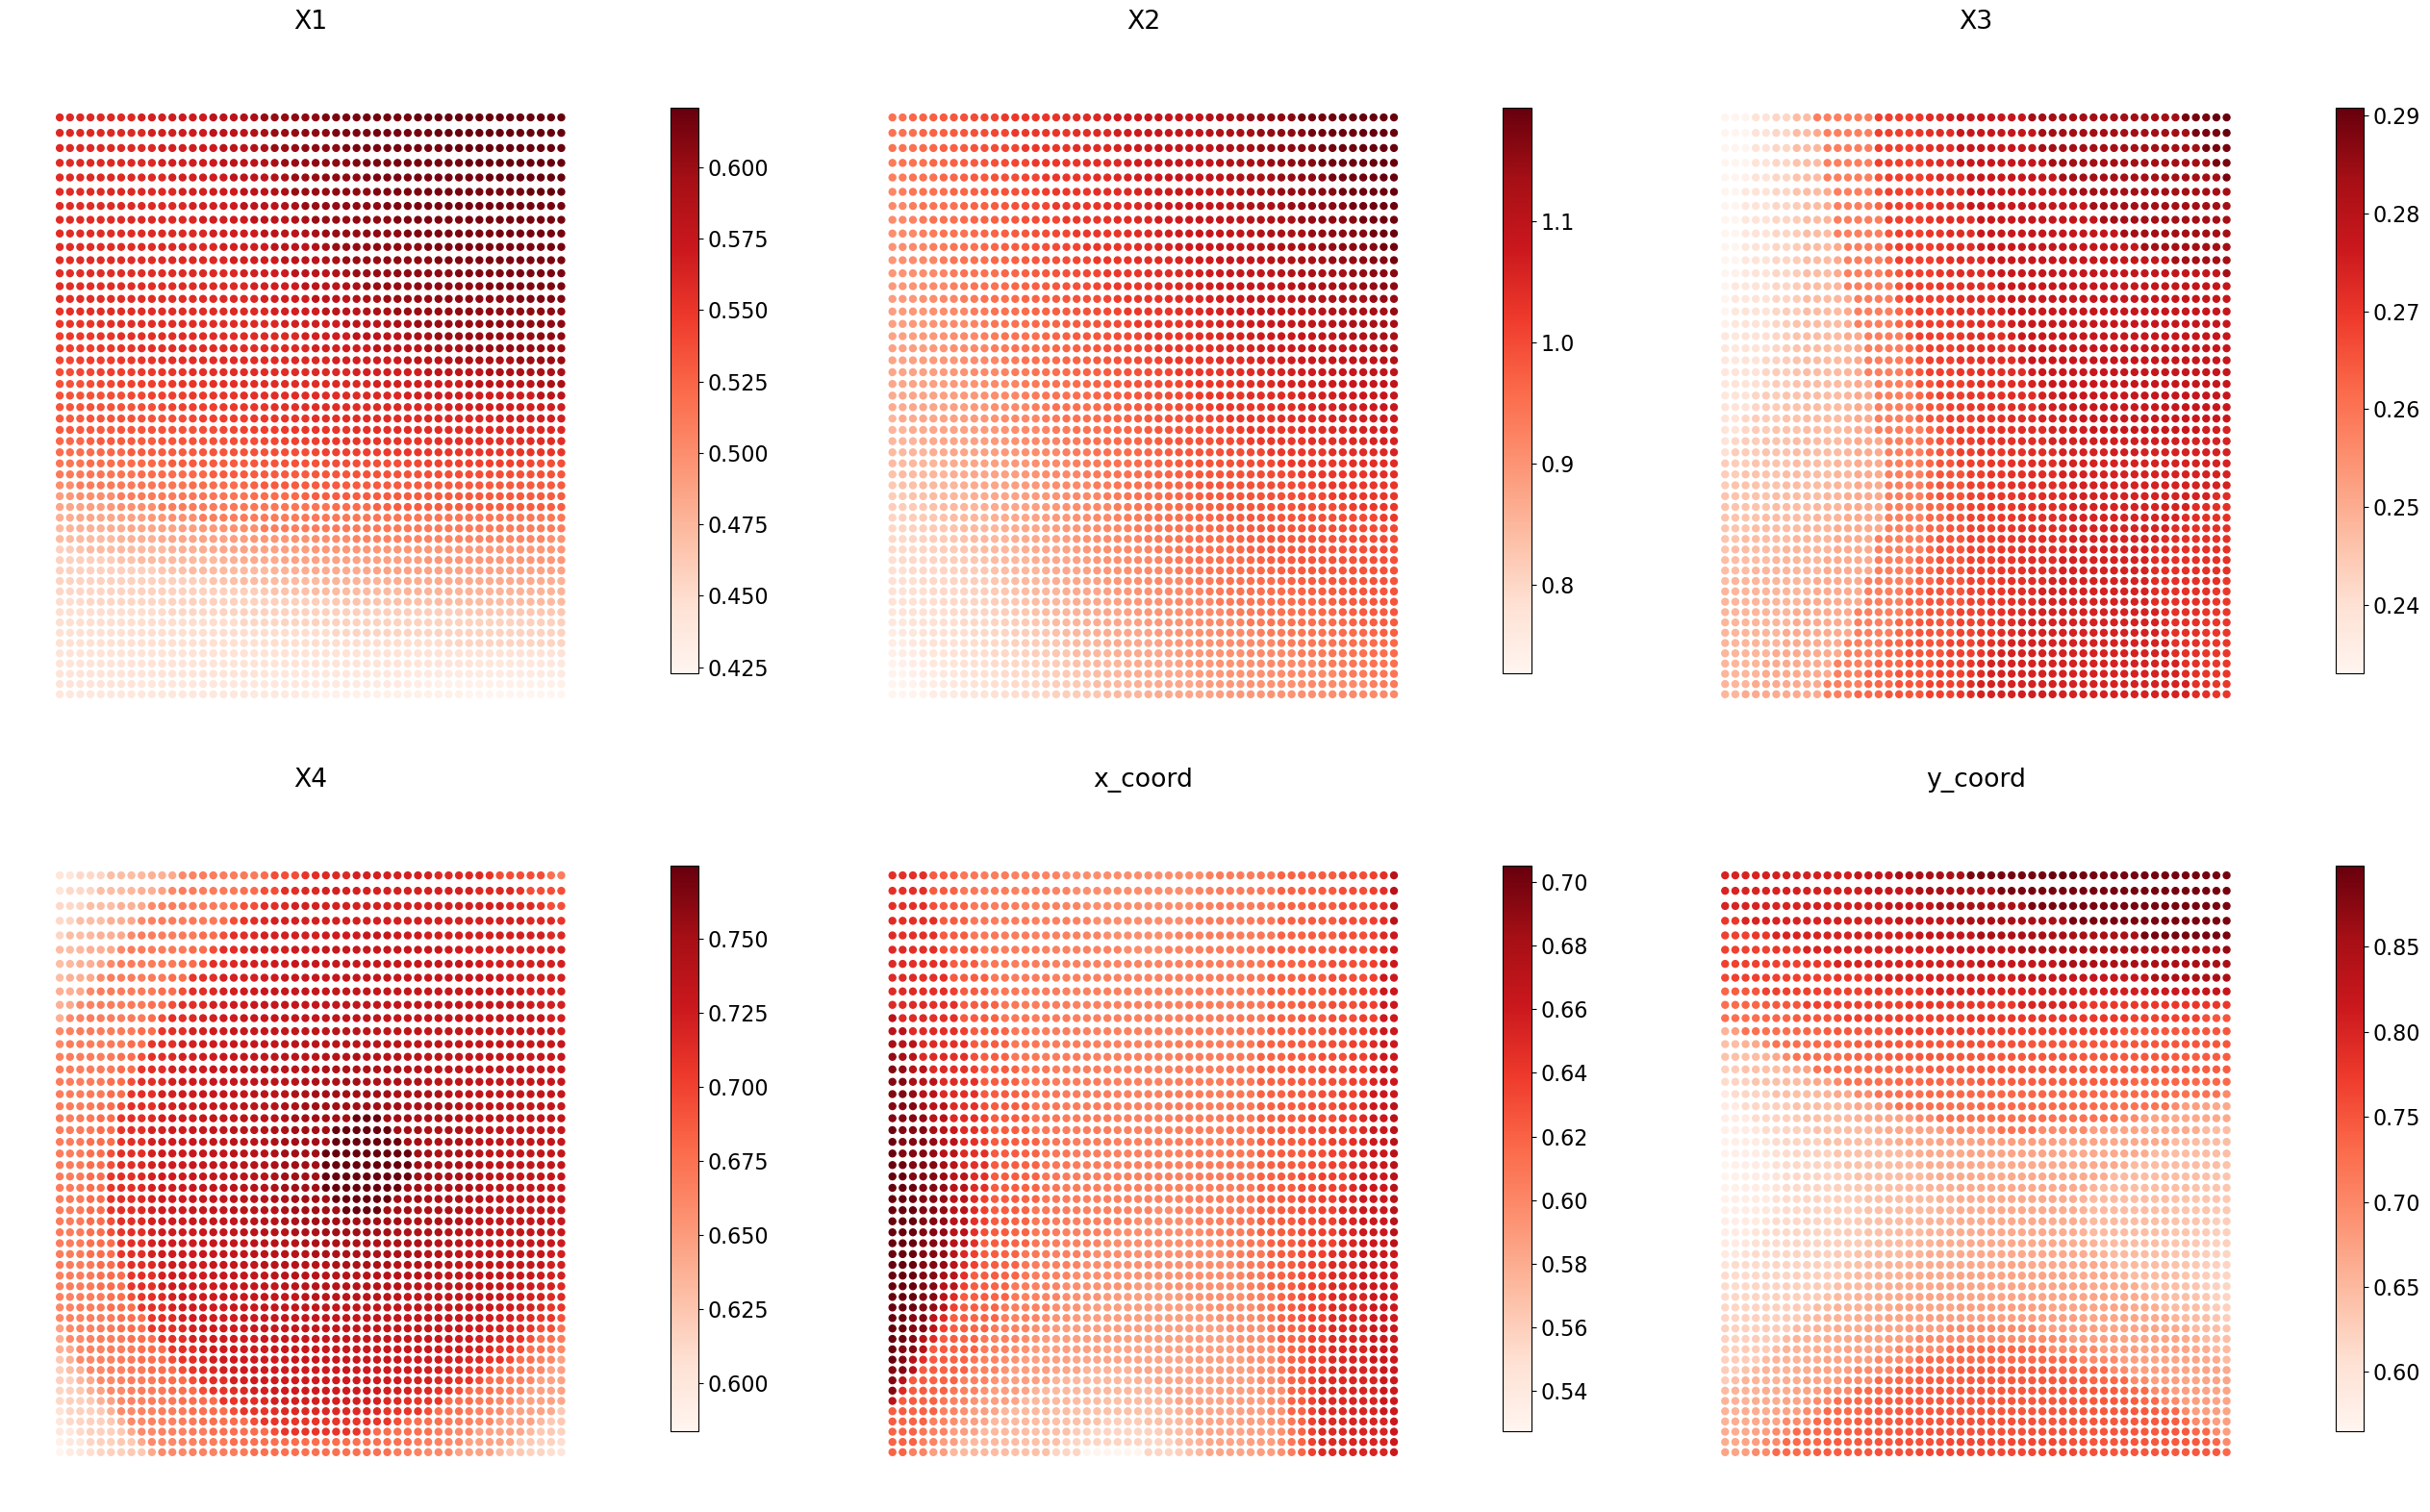

In [30]:
results.plot_geo_uncertainty(max_cols = 3, figsize=[30, 16], basemap=False)

In [31]:
geo_uncertainty_sum = b1 * pred_results['X1_geo_uncertainty'] + b2 * pred_results['X2_geo_uncertainty'] + b3 * pred_results['X3_geo_uncertainty'] + b4 * pred_results['X4_geo_uncertainty'] + b5 * pred_results['X5_geo_uncertainty']

In [32]:
sub_titles = [r'$U_t$', r'$U_1$', r'$U_2$', r'$U_3$', r'$U_4$', r'$U_5$']

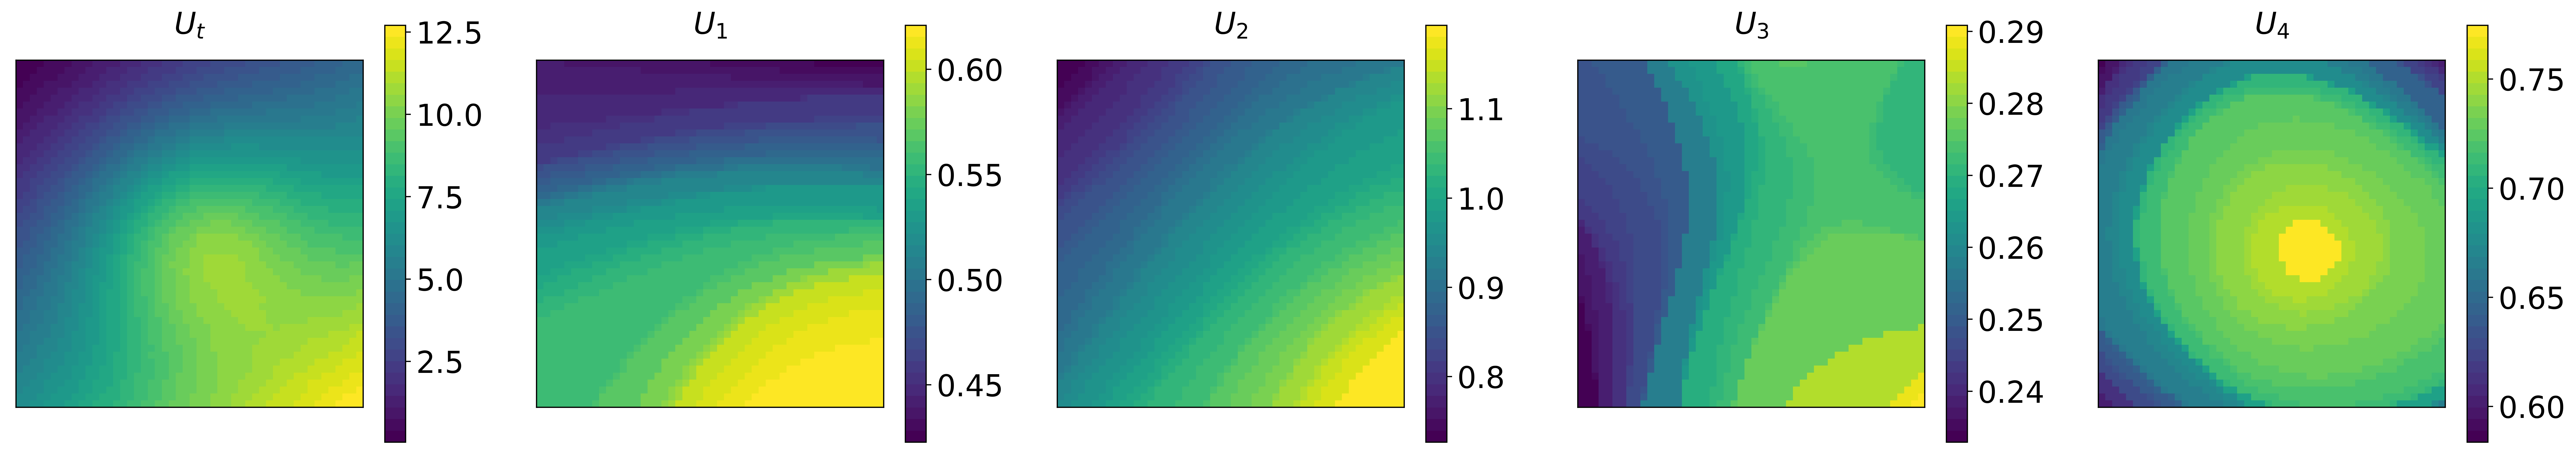

In [33]:
plot_contribution([geo_uncertainty_sum.values, pred_results['X1_geo_uncertainty'].values, pred_results['X2_geo_uncertainty'].values, pred_results['X3_geo_uncertainty'].values], k=4, title='Geo Uncertainty', sub_titles=sub_titles, non_spatial=[])

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

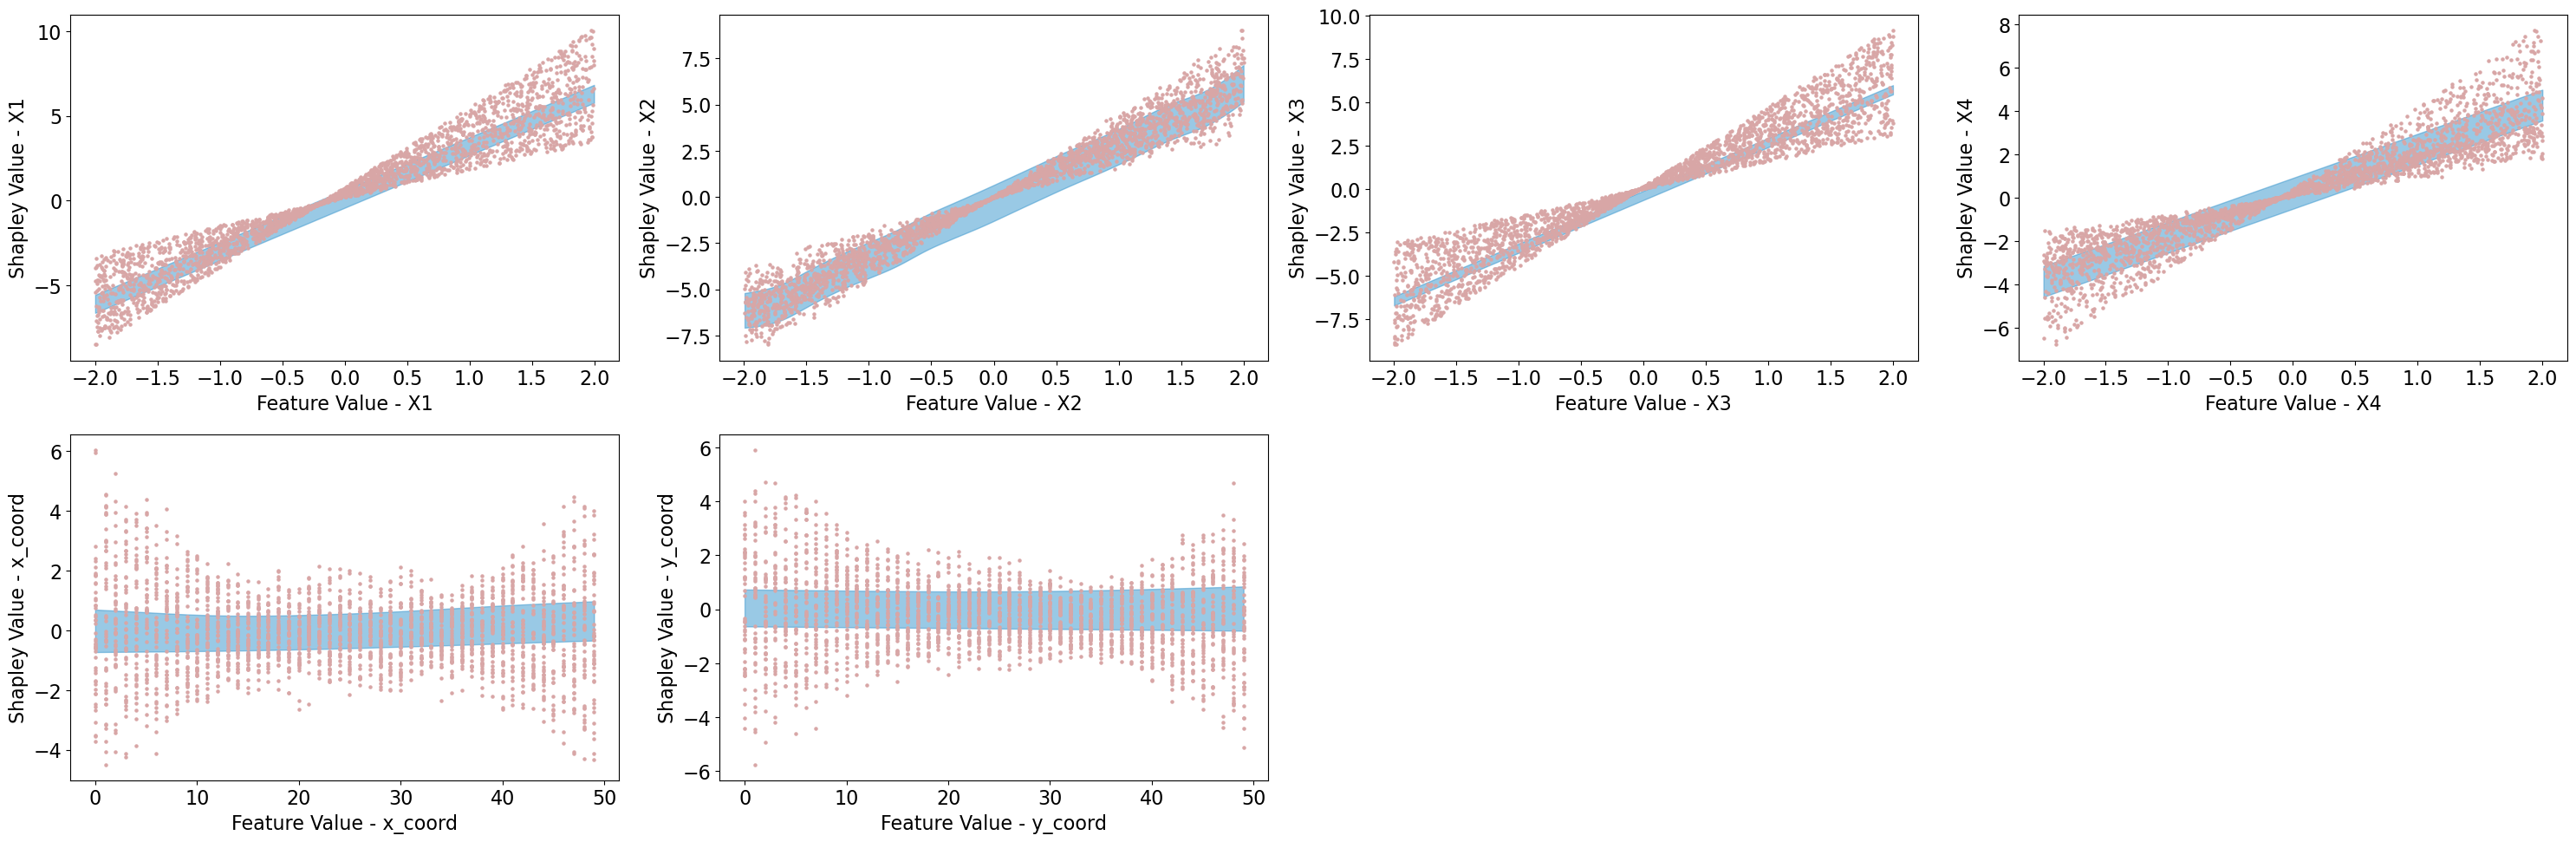

In [35]:
results.plot_partial_dependence_with_fitted_bounds(max_cols=5)